# Read in the data

In [21]:
import pandas
import numpy
import re
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [22]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [23]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [24]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [25]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [26]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [27]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [28]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [29]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)
correlations['rr_s']

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

0.23219912927511965

# Safety And SAT Scores

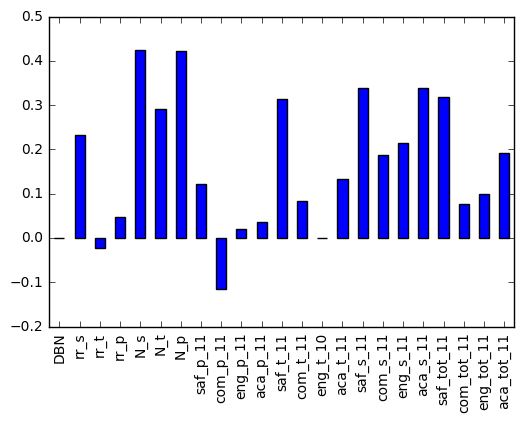

In [30]:
correlations.loc[survey_fields].plot.bar(y='sat_score')
plt.show()

## Findings

Assuming that any correlation above 20% is significant, it appears that five correlations worth noting comparing SAT scores to survey results stand out:
+ aca_s_11 (33.94%) - Academic expectations score based on student responses


+ saf_s_11 (33.76%) - Safety and Respect score based on student responses 


+ saf_t_11 (31.38%) - Safety and Respect score based on teacher responses


+ rr_s (23.22%) - Student Response Rate


+ eng_s_11 (21.38%) - Engagement score based on student responses

It does not seem too suprising that a students academic expectations appear to be correlated with SAT scores. One might assume if one aspires to be to have high academic expectations they would be be better prepared for the SAT. Although it woud be nice to back this up with research.

However it is interesting that safety & respect for students and teachers appears to be correlated with SAT scores. Safety is on the second teir of [Maslow's Hiearchy of Needs](https://en.wikipedia.org/wiki/Maslow's_hierarchy_of_needs). It would be interesting to explore why the feeling of safety and respect for students and teachers may help raise SAT scores.

The fourth and fifth does not seem too suprising. If a student feels more engaged with school, they are probably more likley to learn, thus more likely to do better on the SAT and complet surveys about school. However this assumption needs to be backed up with research too.

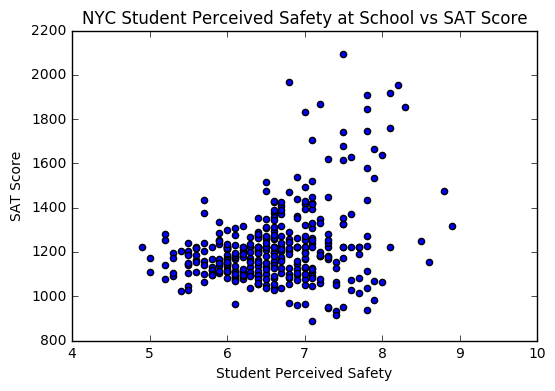

In [31]:
ax = combined.plot.scatter(x='saf_s_11', y='sat_score', title='NYC Student Perceived Safety at School vs SAT Score')
ax.set_xlabel("Student Perceived Safety")
ax.set_ylabel("SAT Score")

plt.show()

## Findings
The scatter plot suggests that there's a weak, positive correlation between the safety of students at NYC public schools and SAT scores. 

It intersting to note that most of perceived studety safety is below a 6.5. Of the student safety ratings below 6.5, none of the schools acheived a SAT score above 1600. 

While when perceived student saftey is above 6.5, schools acheived a wide range of SAT scores. As high as over 2000 and as low as less than 1000. 

In [32]:
districts = combined.groupby("school_dist").agg(numpy.mean)

districts.reset_index(inplace=True)


In [33]:
import folium
from folium import plugins

schools_map = folium.Map(location=[combined['lat'].mean(), combined['lon'].mean()], zoom_start=10)
marker_cluster = folium.MarkerCluster().add_to(schools_map)
for name, row in combined.iterrows():
    folium.Marker([row["lat"], row["lon"]], popup="{0}: {1}".format(row["DBN"], row["school_name"])).add_to(marker_cluster)
schools_map

## Findings

The visual map reveals that perceived student safety and respect is relatively lower in Manhattan, lower portions of The Bronx and in Queens along the East River. A small subset relatively low student perceived saftey and respect seems to exsit in the lower portions of Brooklyn also. 

Perceived studenty saftey and respect is appears to be relatively higher in the central part of Brooklyn, the easten edges of Queens and Staten Island. 

# Race and SAT Scores

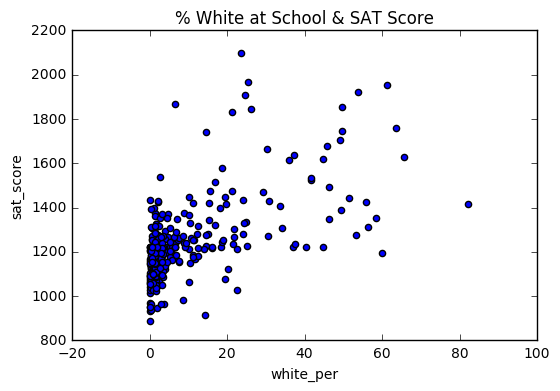

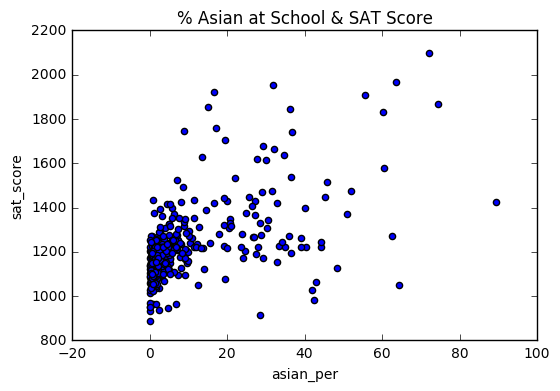

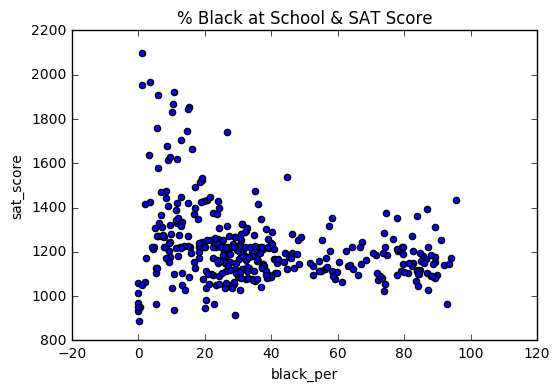

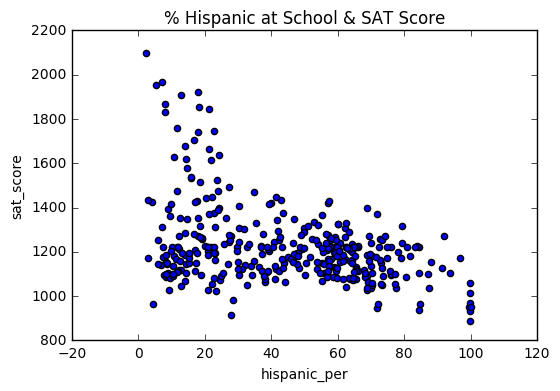

In [34]:
from pandas.tools.plotting import scatter_matrix

race = ['white_per','asian_per','black_per','hispanic_per']
title = ['% White at School & SAT Score','% Asian at School & SAT Score','% Black at School & SAT Score','% Hispanic at School & SAT Score']


for index, item in enumerate(race):
    combined.plot.scatter(race[index], 'sat_score', title=title[index])
    

## Findings

The scatter plots suggest there's weak, positive corrleation between white / asian students and SAT Scores. 

The scatter plot also suggest there's a weak, negative correlation between black / hispanic students and SAT Scores. More strongly correlated than the weak, positive corrleation between white / asian students.

The negative correlation between black / hispanic students seems to start at roughly 20% of hispanics or blacks per student. 




In [35]:
cols = ['SCHOOL NAME','hispanic_per','sat_score','school_type','school_dist','city']
hispanic = combined[cols]

hisp_sch_95 = hispanic[hispanic['hispanic_per'] > 95]

hisp_sch_95


,SCHOOL NAME,hispanic_per,sat_score,school_type,school_dist,city
44,MANHATTAN BRIDGES HIGH SCHOOL,99.8,1058.0,0,02,New York
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,96.7,1174.0,0,06,New York
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,99.8,1014.0,0,06,New York
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,99.4,951.0,0,09,Bronx
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,99.8,934.0,0,10,Bronx
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,99.8,970.0,International School,12,Bronx
253,MULTICULTURAL HIGH SCHOOL,99.8,887.0,0,19,Brooklyn
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,100.0,951.0,International School,24,Elmhurst


## Findings

Most of these schools have a high percentage of economically disadvantaged students according to US News. 

Also interesting to note that is that many of schools did better in math compared to english. Since the majority of these schools are for immigrants where english is not there first language.

In [36]:
hisp_sch_10 = hispanic[hispanic['hispanic_per'] < 10]

hisp_sch_10_1800 = hisp_sch_10[hisp_sch_10['sat_score'] > 1800]

hisp_sch_10_1800

,SCHOOL NAME,hispanic_per,sat_score,school_type,school_dist,city
37,STUYVESANT HIGH SCHOOL,2.4,2096.0,Specialized School,02,New York
151,BRONX HIGH SCHOOL OF SCIENCE,7.2,1969.0,Specialized School,10,Bronx
187,BROOKLYN TECHNICAL HIGH SCHOOL,7.9,1833.0,Specialized School,13,Brooklyn
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,7.9,1868.0,Specialized School,28,Jamaica
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,5.3,1953.0,Specialized School,31,Staten Island


## Findings

All of these schools are specialized schools. They require admissions tests to get in. The have a low percentage of hispanic students in them. In US News reports most of schools were reported to be better in English than Math. Though by a small percentage.  



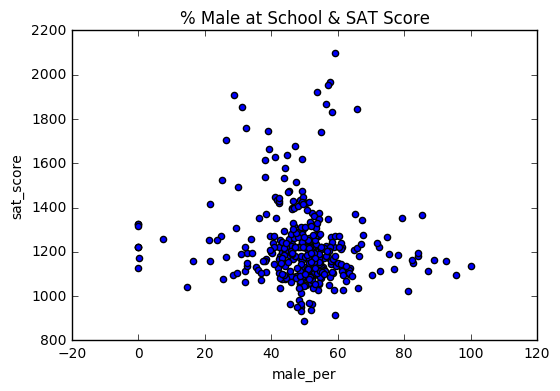

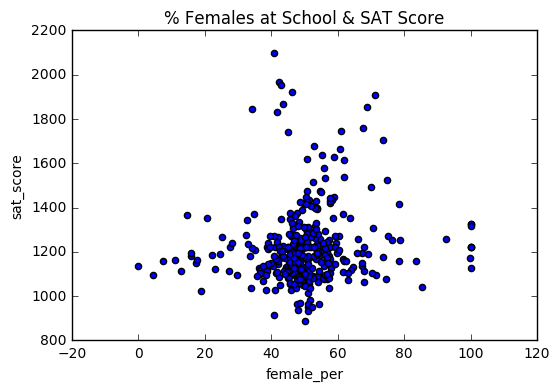

In [37]:
gender = ['male_per','female_per']
title = ['% Male at School & SAT Score','% Females at School & SAT Score']


for index, item in enumerate(gender):
    combined.plot.scatter(gender[index], 'sat_score', title=title[index])

## Findings

The scatter plots suggest there's no positive or weak correlation. Large clumps of SAT scores are between 40-60%.

As the percentage of females increase between 60% - 80%, there tends to be higher SAT scores among females than males. 

The same can be said as the percentage of males decrease from 40% - 20%, there tends to be a higher SAT among males.

Suggesting that schools with a higher percentage of females tend to do better on the SAT than schools with a higher percentage of males.

In [38]:
cols = ['SCHOOL NAME','female_per','sat_score','school_type','school_dist','city']
female = combined[cols]

female = female[female['sat_score'] > 1700]

female




,SCHOOL NAME,female_per,sat_score,school_type,school_dist,city
5,BARD HIGH SCHOOL EARLY COLLEGE,68.7,1856.0,0,01,New York
26,ELEANOR ROOSEVELT HIGH SCHOOL,67.5,1758.0,0,02,New York
37,STUYVESANT HIGH SCHOOL,40.7,2096.0,Specialized School,02,New York
60,BEACON HIGH SCHOOL,61.0,1744.0,Consortium School,03,New York
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,73.6,1707.0,Specialized School,03,New York
79,"HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...",34.2,1847.0,Specialized School,05,New York
151,BRONX HIGH SCHOOL OF SCIENCE,42.2,1969.0,Specialized School,10,Bronx
155,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE,46.2,1920.0,Specialized School,10,Bronx
187,BROOKLYN TECHNICAL HIGH SCHOOL,41.7,1833.0,Specialized School,13,Brooklyn
198,"BROOKLYN LATIN SCHOOL, THE",45.1,1740.0,Specialized School,14,Brooklyn


## Findings

Again all these schools have tests and admission requirements to get in. The schools are selective. Which is probably the main reason why their SAT scores are higher. 

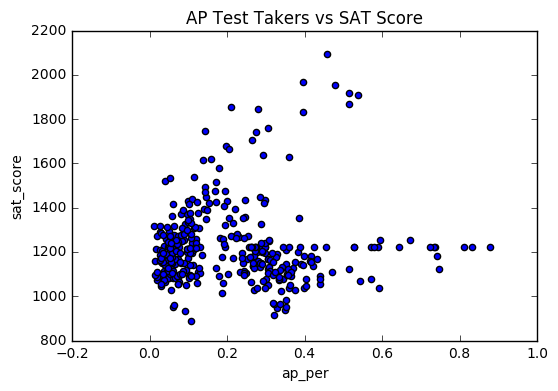

In [39]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

combined.plot.scatter('ap_per','sat_score', title='AP Test Takers vs SAT Score')

## Findings
A couple of trends seem to stand out. One is that after certain about of people in school take the AP Tests, it does not necessary mean a higher SAT score. After 40% of schools are AP Test Takers, there seems to be a gap of over 700 points. I am curious why some schools SAT scores level out at a certain range of AP Test takers while others increase

# Class Size and SAT Score

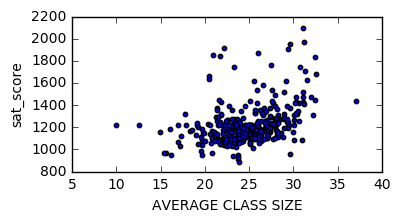

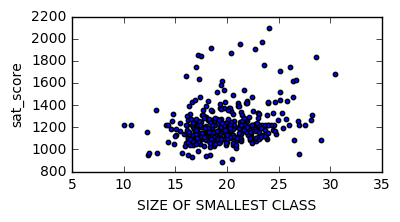

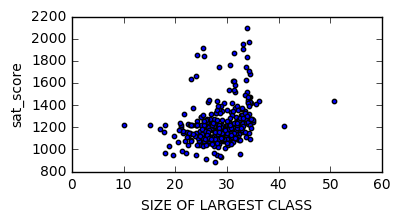

In [56]:
combined.plot.scatter('AVERAGE CLASS SIZE','sat_score', s=10, figsize=(4, 2))

combined.plot.scatter('SIZE OF SMALLEST CLASS','sat_score', s=10, figsize=(4, 2))

combined.plot.scatter('SIZE OF LARGEST CLASS','sat_score',s=10, figsize=(4, 2))


## Findings
The scatter plots suggest there's a positive, weak correlation between the size of the class and SAT Score.




In [59]:
cols = ['AVERAGE CLASS SIZE','SIZE OF SMALLEST CLASS','SIZE OF LARGEST CLASS']

correlations[cols]

AVERAGE CLASS SIZE        0.381014
SIZE OF SMALLEST CLASS    0.249949
SIZE OF LARGEST CLASS     0.314434
Name: sat_score, dtype: float64

## Findings

It appears that average class size has the highest correlation to SAT score. Then size of largest class and finally size of smallest class.

Why does having a larger class tend to increase the SAT score?

In [82]:
combined['Num of SAT Test Takers'] = pandas.to_numeric(combined['Num of SAT Test Takers'], errors="coerce")

In [98]:

cols = ['SCHOOL NAME','AVERAGE CLASS SIZE','sat_score','white_per','asian_per','hispanic_per']

large_class = combined[combined['AVERAGE CLASS SIZE'] < 20]
large_class[cols]

,SCHOOL NAME,AVERAGE CLASS SIZE,sat_score,white_per,asian_per,hispanic_per
6,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,16.072727,1182.000000,6.3,1.7,59.2
8,ESSEX STREET ACADEMY,14.900000,1156.000000,7.6,4.1,60.6
20,THE HIGH SCHOOL FOR LANGUAGE AND DIPLOMACY,17.854545,1223.438806,5.3,44.3,32.8
35,VANGUARD HIGH SCHOOL,19.216667,1199.000000,4.5,9.9,59.0
55,"URBAN ASSEMBLY SCHOOL FOR MEDIA STUDIES, THE",19.807692,1144.000000,3.0,2.2,56.0
56,THE URBAN ASSEMBLY SCHOOL FOR GREEN CAREERS,10.000000,1223.438806,1.8,1.8,76.0
68,PARK EAST HIGH SCHOOL,19.040000,1128.000000,0.3,4.9,59.6
83,HIGH SCHOOL FOR EXCELLENCE AND INNOVATION,17.000000,1223.438806,0.0,0.0,72.5
91,INTERNATIONAL COMMUNITY HIGH SCHOOL,16.200000,945.000000,2.0,4.8,71.8
106,PABLO NERUDA ACADEMY FOR ARCHITECTURE AND WORL...,19.676923,1038.000000,1.4,2.5,69.9


In [43]:
list(combined)

['DBN',
 'SCHOOL NAME',
 'Num of SAT Test Takers',
 'SAT Critical Reading Avg. Score',
 'SAT Math Avg. Score',
 'SAT Writing Avg. Score',
 'sat_score',
 'SchoolName',
 'AP Test Takers ',
 'Total Exams Taken',
 'Number of Exams with scores 3 4 or 5',
 'Demographic',
 'School Name',
 'Cohort',
 'Total Cohort',
 'Total Grads - n',
 'Total Grads - % of cohort',
 'Total Regents - n',
 'Total Regents - % of cohort',
 'Total Regents - % of grads',
 'Advanced Regents - n',
 'Advanced Regents - % of cohort',
 'Advanced Regents - % of grads',
 'Regents w/o Advanced - n',
 'Regents w/o Advanced - % of cohort',
 'Regents w/o Advanced - % of grads',
 'Local - n',
 'Local - % of cohort',
 'Local - % of grads',
 'Still Enrolled - n',
 'Still Enrolled - % of cohort',
 'Dropped Out - n',
 'Dropped Out - % of cohort',
 'CSD',
 'NUMBER OF STUDENTS / SEATS FILLED',
 'NUMBER OF SECTIONS',
 'AVERAGE CLASS SIZE',
 'SIZE OF SMALLEST CLASS',
 'SIZE OF LARGEST CLASS',
 'SCHOOLWIDE PUPIL-TEACHER RATIO',
 'Name',

# Best Area to Live Base on School Performance